In [1]:
# %matplotlib inline
# !pip install deeptrack

# Example 1. Trajectory linking using MAGIK


In this example, we exemplify how to use [MAGIK](https://arxiv.org/abs/2202.06355) (Motion Analysis through GNN Inductive Knowledge) to track Hela cells in live-cell migration experiments. We will use the DIC-C2DH-HELA dataset (provided as part of the sixth edition of the [Cell Tracking Challeng](http://celltrackingchallenge.net/2d-datasets/)) to train and test our model.

This dataset presents several challenges, namely, high packing density, low signal-to-noise ratio, and a highly heterogeneous intracellular signal due to DIC-highlighted internal structures and organelles.

### 1. Setup

Imports the objects needed for this example:

In [2]:
import deeptrack as dt
from deeptrack.models.gnns.generators import GraphGenerator
from deeptrack.models.gnns import augmentations

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

import tensorflow as tf

import logging
logging.disable(logging.WARNING)

c:\GU\DeepTrack2\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\GU\DeepTrack2\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Importing ``deeptrack`` might produce some warnings if your computer does note have a GPU or CUDA is not correctly installed. These
are not a problem for this application and can be safely ignored.

### 2. Defining the training dataset

The DIC-C2DH-HELA dataset is available as a TensorFlow dataset, which can be downloaded and used with the following
code:

In [3]:
dataset = dt.TensorflowDataset("detection_linking_hela", split="train")

``dataset`` contains two keys: ``nodes`` and ``parenthood``. ``nodes`` is a dictionary containing information about individual 
cells in each frame of the training video:

In [4]:
# Convert to pandas dataframe
nodes_df = pd.DataFrame.from_dict(dataset.nodes())
# Re-arrange columns for better readability (optional)
nodes_df = nodes_df[
    [
        "frame",
        "label",
        "centroid-0",
        "centroid-1",
        "area",
        "mean_intensity",
        "perimeter",
        "eccentricity",
        "solidity",
        "set",
        "parent",
        "solution",
    ]
]

# display the first 20 rows of the dataframe
nodes_df.head(20)

frame  label  centroid-0  centroid-1     area  mean_intensity  perimeter  \
0       0      1    0.380352    0.374826  0.55045        1.000850   0.554182   
1       0      5    0.558919    0.297043  0.61475        1.000476   0.597939   
2       0      9    0.660173    0.478512  0.68535        1.001549   0.640817   
3       0     13    0.449917    0.622128  0.70325        1.005486   0.695595   
4       0     18    0.333749    0.770066  0.72375        0.999667   0.706874   
5       0     22    0.696774    0.808934  0.48150        1.010404   0.528878   
6       0     23    0.842613    0.658550  0.56095        1.006508   0.577525   
7       0     26    0.945899    0.409161  0.40890        1.008140   0.544802   
8       1      1    0.385819    0.397307  0.66700        0.912481   0.761749   
9       1      5    0.545790    0.287657  0.52095        0.908852   0.530772   
10      1      9    0.671630    0.477435  0.70295        0.907514   0.677015   
11      1     13    0.459548    0.638362  0.71205        0.919634   0.757185   
12      1     22    0.694478    0.823970  0.45385        0.913557   0.523878   
13      1     23    0.830759    0.674214  0.52015        0.902815   0.536859   
14      1     26    0.945704    0.415008  0.43630        0.912107   0.595268   
15      1     28    0.106942    0.132246  0.74600        0.913186   0.636037   
16      1     32    0.046012    0.335008  0.20905        0.891460   0.427590   
17      2      1    0.392517    0.400813  0.65075        0.906304   0.716009   
18      2      5    0.540447    0.283588  0.57060        0.907041   0.567022   
19      2      9    0.661074    0.475076  0.71935        0.904135   0.678932   

    eccentricity  solidity  set  parent  solution  
0       0.708809  0.950937  0.0       0       0.0  
1       0.593863  0.948103  0.0       0       0.0  
2       0.838893  0.946485  0.0       0       0.0  
3       0.858357  0.929242  0.0       0       0.0  
4       0.797882  0.875469  0.0       0       0.0  
5       0.780721  0.950266  0.0       0       0.0  
6       0.787226  0.944837  0.0       0       0.0  
7       0.904879  0.939676  0.0       0       0.0  
8       0.736533  0.789770  0.0       0       0.0  
9       0.703586  0.953946  0.0       0       0.0  
10      0.811640  0.900871  0.0       0       0.0  
11      0.793109  0.923661  0.0       0       0.0  
12      0.766268  0.912812  0.0       0       0.0  
13      0.751046  0.954141  0.0       0       0.0  
14      0.919042  0.904342  0.0       0       0.0  
15      0.638245  0.976312  0.0       0       0.0  
16      0.781233  0.800651  0.0       0       0.0  
17      0.766273  0.808034  0.0       0       0.0  
18      0.604095  0.956660  0.0       0       0.0  
19      0.817417  0.929693  0.0       0       0.0

``nodes_df`` contains the following columns:

- ``frame``: Frame of the video where the cell was detected

- ``label``: Label assigned to the cell's trajectory

- ``centroid-0``: X-centroid coordinate. The coordinate system is defined such that the top-left corner of the image is (0, 0). 

- ``centroid-1``: Y-centroid coordinate. 

- ``area``: Area covered by the cell. 

- ``mean-intensity``: Mean intensity of pixels within the cell. 

- ``perimeter``: perimeter covered by the cell. 

- ``eccentricity``: Eccentricity of the cell shape. 

- ``solidity``: Solidity of the cell shape. 

- ``set``: Refers to the video from which the cell was detected. For this dataset, there is only one video, so all cells are in the same set, 
i.e., ``set`` is always 0. However, this column is useful for datasets with multiple videos, where each video is assigned a different set number. 

- ``parent``: label of the parent cell. If the cell is a root cell (i.e., a cell that was not linked to any other cell in the previous frame), 
then ``parent`` is set to 0.

- ``solution``: Ground truth solution used for node classification/regression tasks. We will ignore this column for now since
we are only interested in tracking the cells.

Importantly, There are no intrinsic restrictions on the type or number of descriptors (e.g., location and morphological features, image-based quantitiesn) that can be encoded in the node representation. 

``parenthood``, in turn, includes information on the lineage of the cells, essential for training data where cell division events are present:

In [5]:
parenthood_df = pd.DataFrame.from_dict(dataset.parenthood())

# display dataframe
parenthood_df

child  parent
0       2       1
1       4       1
2       6       5
3       8       5
4      11       9
5      12       9
6      16      13
7      17      13
8      21      20
9      27      26
10     34      42
11     43      28
12     44      28

MAGIK models objects’ motion and physical interactions using a graph representation. Graphs can define arbitrary relational structures between nodes connecting them pairwise through edges.

For detection linking, MAGIK aims to prune the graph edges to a minimal set that adequately describes the motion of the cells and their interactions. This is essentially an *edge-classification* problem where the goal is to predict whether or not two cells (nodes in the graph) are linked in the next frame. We thus define:

In [6]:
_OUTPUT_TYPE = "edges"

In MAGIK, nodes are connected to spatio-temporal neighbors within a likelihood radius:

In [7]:
# Distance-based likelihood radius
radius = 0.2

Finally, we create a dummy feature to store our configuration for the graph generation process:

In [8]:
variables = dt.DummyFeature(
    radius=radius,
    output_type=_OUTPUT_TYPE,
    nofframes=3, # Time window to associate nodes (in frames) 
)

### 3. Defining MAGIK

MAGIK is defined using the function ``dt.models.MAGIK``. This function receives the following arguments:

- ``number_of_node_features``: Number of features in the node representation.

- ``number_of_edge_features``: Number of features in the edge representation.

- ``dense_layer_dimensions``: Dimensions of the dense layers used to encode the node and edge representations. It is a tuple of integers, where each integer corresponds to the number of units in a dense layer. MAGIK defines the decoder as a reversed version of the encoder, so the number of dense layers and their dimensions defined by this argument is also used for the decoder.

- ``base_layer_dimensions``: Dimensions of the message-passing layers used to process the graph representation. It is a tuple of integers, where each integer corresponds to the number of units in a message-passing layer. These layers receive the encoded node and edge representations and propagate information through the graph. Importantly, the dimensions of the message-passing layers must be chosen such that it is divisible by the number of self-attention heads in each layer (by default, this is 12).

- ``output_type``: Type of output to be generated by the model. It can be either ``"node"``, ``"edges"``, or ``"graph"`` (yields the entire graph representation). In this example, we will use ``"edges"`` since we are interested in *edge* classification. 

- ``number_of_edge_outputs``: Number of edge outputs. This is only relevant if ``output_type`` is ``"edges"`` or ``"graph"``. In this example, we will use ``1`` since we are only interested in predicting the probability of a link between two nodes. 

- ``edge_output_activation``: Activation function to be used for the edge outputs. For a binary classification problem, we will use ``"sigmoid"``.

In [9]:
model = dt.models.MAGIK(
    number_of_node_features=7,          
    number_of_edge_features=1,         
    dense_layer_dimensions=(32, 64, 96),    
    base_layer_dimensions=(96, 96), 
    output_type=_OUTPUT_TYPE,           
    number_of_edge_outputs=1,           
    edge_output_activation="sigmoid",   
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
node_ide1 (Dense)               (None, None, 32)     256         input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 multiple             0           node_ide1[0][0]                  
                                                                 edge_ide1[0][0]                  
                                                                 node_ide2[0][0]                  
                                                                 edge_ide2[0][0]       

Next, we compile the network using *binary cross-entropy* as the loss function and *Adam* as the optimizer:

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)

### 4. Training the model

Before training MAGIK, we use the ``GraphGenerator`` function to create the graph representaton for the training set. ``GraphGenerator`` returns a *continuous generator* that generates augmented graphs asynchronously from the training graph representation. 

This process involves randomly sampling the training graph and applying random transformations to the sampled set, such as rotation, translation, and scaling. Moreover, some nodes and their connections are removed randomly from the sampled graph to account for detection blinking:

In [11]:
def GetFeature(full_graph, **kwargs):
    return (
        dt.Value(full_graph)
        >> dt.Lambda(
            augmentations.GetSubSet,
            randset=lambda: np.random.randint(
                np.max(full_graph[-1][0][:, 0]) + 1
            ),
        )
        >> dt.Lambda(
            augmentations.GetSubGraph,
            num_nodes=lambda min_num_nodes, max_num_nodes: np.random.randint(
                min_num_nodes, max_num_nodes
            ),
            node_start=lambda num_nodes: np.random.randint(
                max(len(full_graph[0][0]) - num_nodes, 1)
            ),
            min_num_nodes=700,
            max_num_nodes=1500,
        )
        >> dt.Lambda(
            augmentations.AugmentCentroids,
            rotate=lambda: np.random.rand() * 2 * np.pi,
            translate=lambda: np.random.randn(2) * 0.05,
            flip_x=lambda: np.random.randint(2),
            flip_y=lambda: np.random.randint(2),
        )
        >> dt.Lambda(augmentations.NoisyNode)
        >> dt.Lambda(augmentations.NodeDropout, dropout_rate=0.03)
    )


The augmentation pipeline is passed to the ``GraphGenerator`` function to create the generator:

In [12]:
properties = [
    "centroid",
    "area",
    "mean_intensity",
    "perimeter",
    "eccentricity",
    "solidity",
]

generator = GraphGenerator(
    nodesdf=nodes_df,
    properties=properties,
    parenthood=parenthood_df,
    min_data_size=511,
    max_data_size=512,
    batch_size=8,
    feature_function=GetFeature,
    **variables.properties()
)


  0%|          | 0/1 [00:00<?, ?it/s]

Creating graph edges...


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Now, we train MAGIK using ``generator``:

In [13]:
with generator:
    model.fit(generator, epochs=10)

Generating 512 / 511 samples before starting training
Epoch 1/10


c:\GU\DeepTrack2\deeptrack\image.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.to_numpy()._value)


63/63 [==============================] - 5s 85ms/step - loss: 0.0934 - accuracy: 0.9589
Epoch 2/10
63/63 [==============================] - 6s 91ms/step - loss: 0.0229 - accuracy: 0.9921
Epoch 3/10
63/63 [==============================] - 5s 86ms/step - loss: 0.0139 - accuracy: 0.9953
Epoch 4/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0078 - accuracy: 0.9978
Epoch 5/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0051 - accuracy: 0.9987
Epoch 6/10
63/63 [==============================] - 6s 89ms/step - loss: 0.0037 - accuracy: 0.9991
Epoch 7/10
63/63 [==============================] - 5s 86ms/step - loss: 0.0026 - accuracy: 0.9994
Epoch 8/10
63/63 [==============================] - 5s 86ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 9/10
63/63 [==============================] - 5s 85ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 10/10
63/63 [==============================] - 5s 84ms/step - loss: 0.0018 - accuracy: 0.9996


### 5. Evaluating the network

The test dataset is also available as a TensorFlow dataset, which can be downloaded and used with the following code:

In [14]:
test_dataset = dt.TensorflowDataset("detection_linking_hela", split="test")

Similar to the training dataset, ``test_dataset`` contains ``nodes``

In [15]:
test_nodes_df = pd.DataFrame.from_dict(test_dataset.nodes())
# Re-arrange columns for better readability (optional)
test_nodes_df = test_nodes_df[
    [
        "frame",
        "label",
        "centroid-0",
        "centroid-1",
        "area",
        "mean_intensity",
        "perimeter",
        "eccentricity",
        "solidity",
        "set",
        "parent",
        "solution",
    ]
]
test_nodes_df.head(20)

frame  label  centroid-0  centroid-1     area  mean_intensity  perimeter  \
0       0      1    0.386923    0.321226  0.68825        1.013773   0.633745   
1       0      5    0.292010    0.642319  0.45550        1.005137   0.612147   
2       0      7    0.583598    0.328959  0.75035        1.016577   0.662947   
3       0     11    0.427139    0.633198  0.42760        1.020798   0.468855   
4       0     15    0.747349    0.158783  0.73450        1.013246   0.649589   
5       0     19    0.820078    0.382870  0.61545        1.016006   0.620572   
6       0     23    0.640371    0.608362  0.51470        1.021778   0.567806   
7       0     27    0.573497    0.828045  0.44060        1.014910   0.478915   
8       0     32    0.082451    0.564590  0.49520        1.003298   0.553426   
9       0     34    0.115706    0.931589  0.32330        1.009771   0.425608   
10      1      1    0.390864    0.324484  0.66800        0.915933   0.614485   
11      1      5    0.244030    0.658507  0.43250        0.902869   0.547140   
12      1      7    0.585040    0.342284  0.73800        0.922944   0.709234   
13      1     11    0.377914    0.633372  0.43050        0.920146   0.481437   
14      1     15    0.740484    0.167009  0.74210        0.915959   0.647259   
15      1     19    0.813888    0.399804  0.64435        0.913078   0.613036   
16      1     23    0.633328    0.651758  0.39805        0.924823   0.452176   
17      1     27    0.581940    0.840862  0.46340        0.921414   0.482147   
18      1     32    0.080382    0.564848  0.42830        0.879186   0.477132   
19      1     34    0.114597    0.923768  0.34545        0.891334   0.422376   

    eccentricity  solidity  set  parent  solution  
0       0.806396  0.943584  0.0       0       0.0  
1       0.920109  0.854677  0.0       0       0.0  
2       0.843379  0.964274  0.0       0       0.0  
3       0.595472  0.964258  0.0       0       0.0  
4       0.762810  0.957128  0.0       0       0.0  
5       0.860112  0.958048  0.0       0       0.0  
6       0.674413  0.936329  0.0       0       0.0  
7       0.554244  0.956786  0.0       0       0.0  
8       0.789385  0.941624  0.0       0       0.0  
9       0.540185  0.980588  0.0       0       0.0  
10      0.751472  0.956472  0.0       0       0.0  
11      0.878967  0.883013  0.0       0       0.0  
12      0.855838  0.942950  0.0       0       0.0  
13      0.791947  0.960187  0.0       0       0.0  
14      0.782750  0.948371  0.0       0       0.0  
15      0.872882  0.970845  0.0       0       0.0  
16      0.746856  0.967667  0.0       0       0.0  
17      0.594252  0.960912  0.0       0       0.0  
18      0.792578  0.962148  0.0       0       0.0  
19      0.576955  0.982509  0.0       0       0.0

and ``parenthood`` information

In [16]:
test_parenthood_df = pd.DataFrame.from_dict(test_dataset.parenthood())

# display dataframe
test_parenthood_df

child  parent
0       3       1
1       4       1
2       8       7
3      10       7
4      12      11
5      14      11
6      16      15
7      18      15
8      21      19
9      22      19
10     24      23
11     26      23
12     28      27
13     30      27
14     35      32
15     36      32
16     38      56
17     40      41

Compute predictions for the test set:

In [17]:
pred, gt, scores, graph = dt.models.gnns.get_predictions(
    test_nodes_df,
    properties,
    model,
    parenthood=test_parenthood_df,
    **variables.properties()
)

  0%|          | 0/1 [00:00<?, ?it/s]

Creating graph edges...


100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


Crate dataframe from results:

In [18]:
edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)

# display the first 10 rows of the dataframe
edges_df.head(20)

frame_x  frame_y  node_x  node_y   gt  prediction     score  frame_diff
0       0.0      1.0     0.0    10.0  1.0         1.0  0.999556         1.0
1       0.0      1.0     0.0    12.0  0.0         0.0  0.000592         1.0
2       0.0      1.0     1.0    11.0  1.0         1.0  0.999322         1.0
3       0.0      1.0     1.0    13.0  0.0         1.0  0.981972         1.0
4       0.0      1.0     2.0    10.0  0.0         0.0  0.000592         1.0
5       0.0      1.0     2.0    12.0  1.0         1.0  0.999585         1.0
6       0.0      1.0     3.0    11.0  0.0         0.0  0.000592         1.0
7       0.0      1.0     3.0    13.0  1.0         1.0  0.996494         1.0
8       0.0      1.0     4.0    14.0  1.0         1.0  0.999593         1.0
9       0.0      1.0     5.0    15.0  1.0         1.0  0.999584         1.0
10      0.0      1.0     6.0    16.0  1.0         1.0  0.999417         1.0
11      0.0      1.0     7.0    16.0  0.0         0.0  0.000592         1.0
12      0.0      1.0     7.0    17.0  1.0         1.0  0.999395         1.0
13      0.0      1.0     8.0    11.0  0.0         0.0  0.000592         1.0
14      0.0      1.0     8.0    18.0  1.0         1.0  0.999435         1.0
15      0.0      1.0     9.0    19.0  1.0         1.0  0.998837         1.0
16      0.0      2.0     0.0    20.0  1.0         1.0  0.999547         2.0
17      0.0      2.0     1.0    21.0  1.0         1.0  0.995814         2.0
18      0.0      2.0     1.0    23.0  0.0         0.0  0.051552         2.0
19      0.0      2.0     2.0    20.0  0.0         0.0  0.000592         2.0

Compute the average f1-score for the test set:

In [19]:
print("F1 score: ", f1_score(edges_df["gt"], edges_df["prediction"]))

F1 score:  0.9937702466982308


Compute trajectories, and filter out trajectories less than 8 frames long:

In [20]:
traj = dt.models.gnns.get_traj(edges_df, th = 8)

Display the trajectories on the first 10 frames of the video:

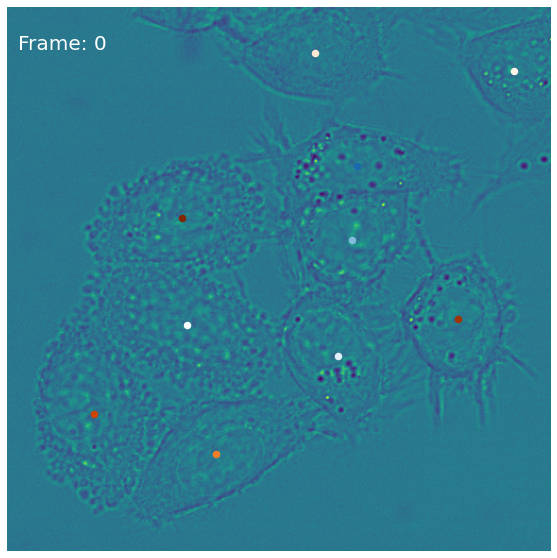

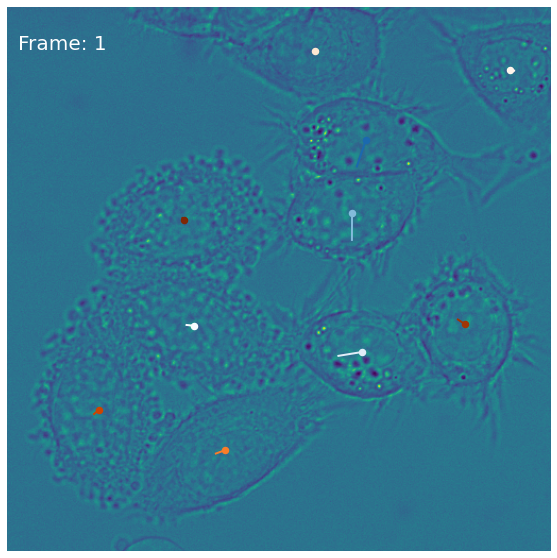

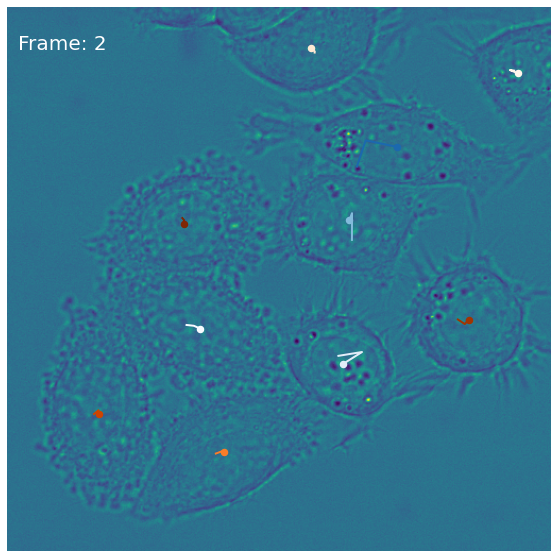

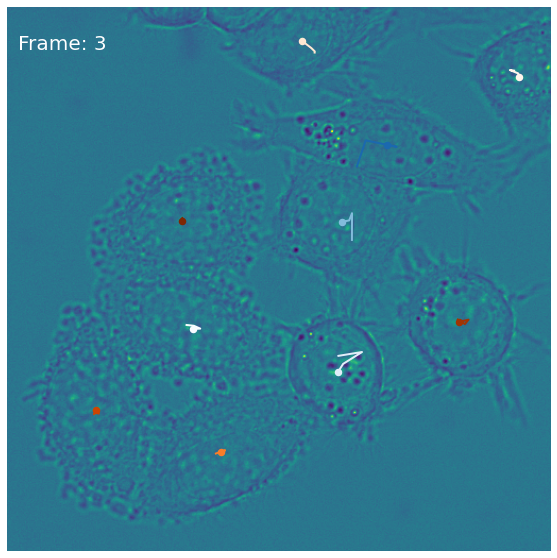

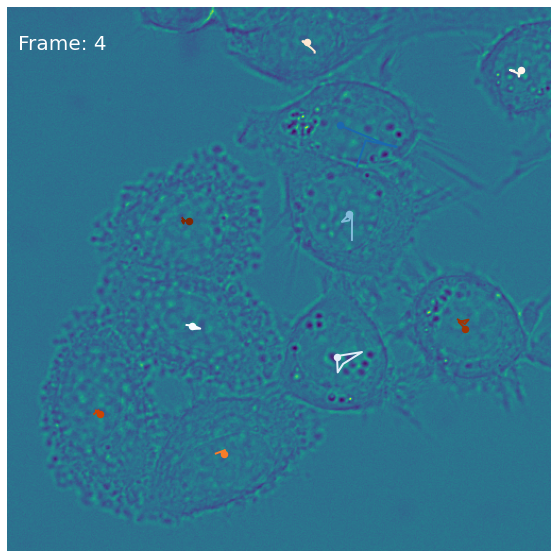

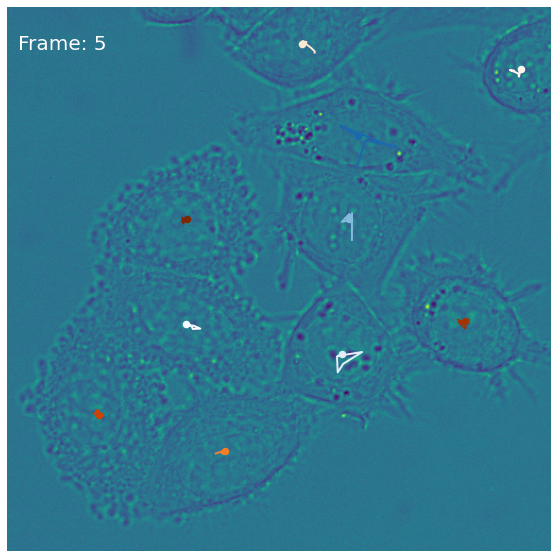

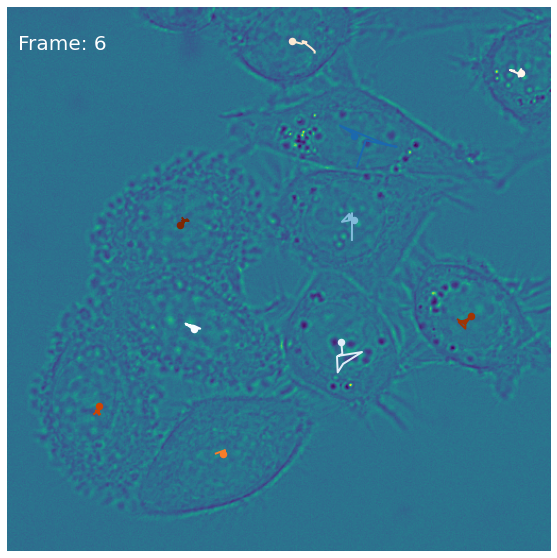

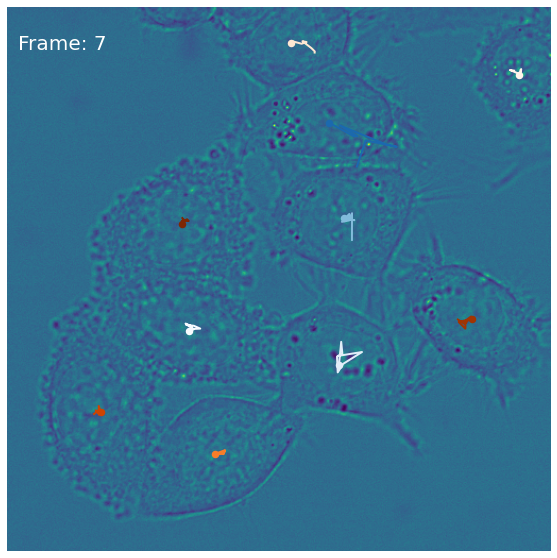

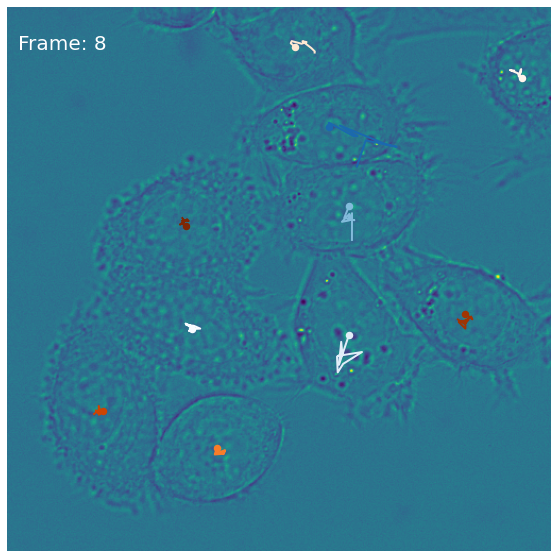

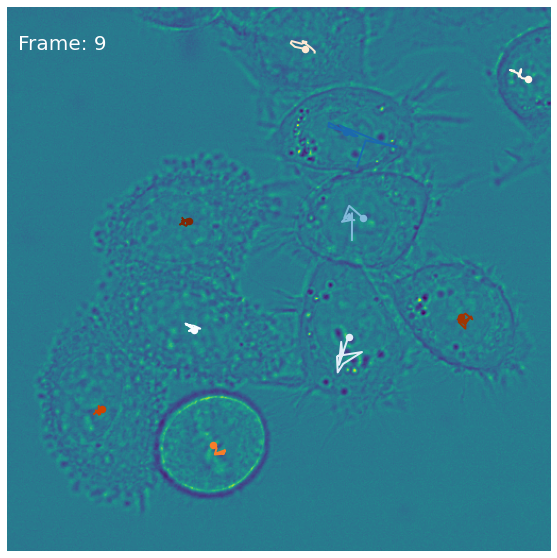

In [21]:
import glob
import cv2

import matplotlib.pyplot as plt

frames = test_dataset.images()[...,0]
nr, nc = frames.shape[1:3]

for f, frame in enumerate(frames[:10]):

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(frame)
    plt.text(10, 40, "Frame: " + str(f), fontsize=20, c="white")
    plt.axis("off")

    for i, (t, c) in enumerate(traj):
        detections = nodes[t][(nodes[t, 0] <= f) & (nodes[t, 0] >= f - 10), :]

        if (len(detections) == 0) or (np.max(nodes[t, 0]) < f):
            continue

        plt.plot(detections[:, 2] * nc, detections[:, 1] * nr, color = c, linewidth=2)
        plt.scatter(detections[-1, 2] * nc, detections[-1, 1] * nr, linewidths=1.5, c = c)
    
    plt.show()